# PASE+ Audio Feature Extractor
Script para provar qué outputs genera PASE+ al utilizar datasets que si tenemos labelled. 

Dependiendo de los resultados pueden aparecer dos caminos:<br><font color=green>- Formar un dataframe con todos los resultados de los workers y etiquetarlo con la duración del audio, id y label.<br>- Realizar un algoritmo básico de ML o usar Q-RNN para comprovar la eficacia de este algorismo y su encierto.<br></font><font color=yellow>+  Build a pre-trained model para provar con otros datasets directamente y ver qué implicaciones puede tener el uso de otros modelos.<br>+ Observar las implicaciones y sesgos de un modelo unsupervised. <br>+ Provar una clasificación con audios no etiquetados. </font>

In [ ]:
import math
import numpy as np
import torch
import torch.nn as nn 
import torch.nn.functional as F 

from sklearn.model_selection import KFold

from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
import os
import glob
from IPython.display import Audio
import librosa.display
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import librosa
warnings.simplefilter(action='ignore', category=FutureWarning)
from torch.utils.data import TensorDataset
from sklearn.metrics import confusion_matrix
import seaborn as sn 
import pandas as pd



## Carga de datasets

T
(75, 128)
75
Label: 6	ID: 03a02Ta	Spectrogram shape: (1, 75, 128)
W
(92, 128)
92
Label: 1	ID: 03a02Wb	Spectrogram shape: (1, 75, 128)
N
(63, 128)
63
Label: 1	ID: 03a02Nc	Spectrogram shape: (0, 75, 128)
F
(82, 128)
82
Label: 5	ID: 03a01Fa	Spectrogram shape: (1, 75, 128)
Data augmented!
N
(70, 128)
70
Label: 5	ID: 03a01Nc	Spectrogram shape: (0, 75, 128)
Data augmented!
F
(87, 128)
87
Label: 5	ID: 03a02Fc	Spectrogram shape: (1, 75, 128)
Data augmented!
W
(81, 128)
81
Label: 1	ID: 03a01Wa	Spectrogram shape: (1, 75, 128)
W
(116, 128)
116
Label: 1	ID: 11a04Wc	Spectrogram shape: (1, 75, 128)
W
(113, 128)
113
Label: 1	ID: 09b02Wd	Spectrogram shape: (1, 75, 128)
F
(138, 128)
138
Label: 5	ID: 03a05Fc	Spectrogram shape: (1, 75, 128)
Data augmented!
T
(387, 128)
387
Label: 6	ID: 08b03Tc	Spectrogram shape: (5, 75, 128)
T
(151, 128)
151
Label: 6	ID: 03a05Tc	Spectrogram shape: (2, 75, 128)
A
(67, 128)
67
Label: 6	ID: 11a04Ac	Spectrogram shape: (0, 75, 128)
T
(89, 128)
89
Label: 6	ID: 11a02Tc	Spectr

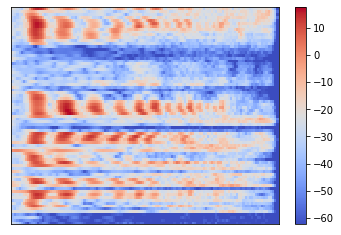

In [ ]:
tpath = "/content/drive/MyDrive/DataSets4Stress/Audio_Emotion/Berlin_EMODB"
data = []
audio = []
labels = []
id = []

spectrograms = np.zeros((1, 75, 128))

for filename in glob.glob(os.path.join(tpath, '*.wav')):
  #print(str(filename))
  x = filename.split("/")
  y = x[7].split(".")
  ids = y[0]
  #print(str(ids))
  id.append(ids)
  z = [char for char in ids if char.isupper()]
  z = str(z).split("[")
  z = z[1].split("'")
  label = str(z[1])
  print(label)
  #labels.append(label)
  sample, sr = librosa.load(filename)
  audio.append(sample)
  duration = len(sample)/sr
  spec = librosa.feature.melspectrogram(
      y= sample,
      sr=sr,
      n_fft= 1024,
      hop_length= 512,
      n_mels= 128,
      fmax= 8000,
      win_length= 400
  )
  spec = librosa.power_to_db(spec).transpose()
  print(spec.shape)
  div = (spec.shape[0] // 75)
  print(spec.shape[0])
  size_new = int(div*75)
  spec = spec[:size_new]
  spec = spec.reshape((div, 75, 128))

  for k in range(div):
    if label == "T":
      lab = int(6)
    elif label == "F":
      lab = int(5)
    elif label == "A":
      lab = int(4)
    elif label == "E":
      lab = int(3)
    elif label == "L":
      lab = int(2)
    elif label == "W":
      lab = int(1)
    else:
      lab = int(0)
    
    labels.append(lab)
  spectrograms = np.concatenate((spectrograms, spec))
  print("Label: "+str(lab)+"\tID: "+str(ids)+"\tSpectrogram shape: "+str(spec.shape) )

  if (lab == 5) or (lab == 4) or (lab == 3) or (lab == 0):
    y_noise = sample
    rms = math.sqrt(np.mean(y_noise**2))
    noise = np.random.normal(0, rms, y_noise.shape[0])
    y_noise = y_noise + noise
    spec_t = librosa.feature.melspectrogram(
      y= sample,
      sr=sr,
      n_fft= 1024,
      hop_length= 512,
      n_mels= 128,
      fmax= 8000,
      win_length= 400
    )
    spec_t = librosa.power_to_db(spec_t).transpose()
    div = (spec_t.shape[0] // 75)
    size_new = int(div*75)
    spec_t = spec_t[:size_new]
    spec_t = spec_t.reshape((div, 75, 128))
    for k in range(div):
      labels.append(lab)
    spectrograms = np.concatenate((spectrograms, spec_t))
    print("Data augmented!")

plt.figure()
spec = spec.reshape((75,128))
librosa.display.specshow(spec)
plt.colorbar()

In [ ]:
spectrograms = spectrograms[1:,:,:]
print(spectrograms.shape, "Spectrograms array")
print(len(labels))

labels = np.asarray(labels, dtype=int)
dataset = TensorDataset(
    torch.from_numpy(spectrograms),
    torch.from_numpy(labels)
)

(863, 75, 128) Spectrograms array
863


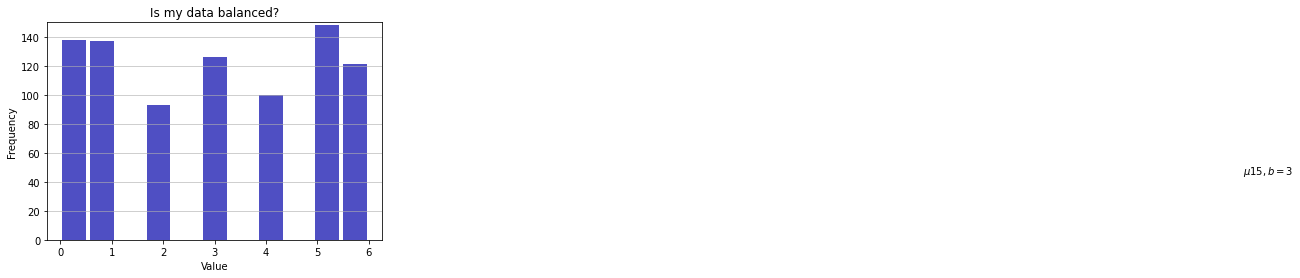

In [ ]:
n, bins, patches = plt.hist(x=labels, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Is my data balanced?')
plt.text(23,45,r'$\mu15, b=3$')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq/10)*10 if maxfreq % 10 else maxfreq + 10)
plt.show()

## USO DE TL Y MODELOS YA ENTRENADOS PARA AUDIO

Usaré TL de un modelo capaz de detectar la depresión. En este sentido, usaré la opción de sacar features hasta la QRNN y la opción de ver si los hyoeroparameters usados por otras opciones es útil.

#### Train test

In [ ]:
def trainXD(epochs, model_mlt, train_loader, optimizer, criterion, iter_meter):
    acc_dep_list = []
    loss_list = []
    label_dep_list = []
    predicted_list_dep = []
    loss_tot_list = []
    accuracy_dep = []

    #Training
    for epoch in range(epochs):
        model_mlt.train()
        total_training_loss = 0

        for x,y in train_loader:
            inputs = x
            label_dep = y.long()
            label_dep_list.extend(label_dep.detach().numpy())

            optimizer.zero_grad()
            phq8 = model_mlt(inputs.float())
            phq8 = phq8.squeeze(0)

            predicted_list_dep.extend((torch.max(torch.exp(F.log_softmax(phq8,dim=1)),1)[1]).detach().numpy())

            loss = criterion_dep(phq8,label_dep)

            loss.backward()
            optimizer.step()
            iter_meter.step()
            total_training_loss += loss

            loss_list.append(loss.item())
            #Track accuracy
            total_dep = label_dep.size(0)
            _, predicted = torch.max(phq8.data,1)
            correct_dep = (predicted == label_dep).sum().item()
            acc_dep_list.append(correct_dep/total_dep)  

        #if epoch == (epochs-1):
        print('Train Epoch: {} \tLoss: {:.4f}\tAccuracy: {:.4f}'.format(
            epoch,
            np.mean(loss_list),
            np.mean(acc_dep_list)
        ))      
        loss_tot_list.append(np.mean(loss_list))
        accuracy_dep.append(np.mean(acc_dep_list))
        
    #Printing Confusion Matrix
    classes_dep = ('0','1','2','3','4','5','6')
    cf_matrix_dep = confusion_matrix(label_dep_list, predicted_list_dep)
    df_cm = pd.DataFrame(cf_matrix_dep/np.sum(cf_matrix_dep)*10,index = [i for i in classes_dep], columns=[i for i in classes_dep])
    plt.figure(figsize=(12,7))
    sn.heatmap(df_cm, annot=True)
    plt.savefig('Confusion Matrix Depression Training')

    fig, axs = plt.subplots(2)
    axs[0].plot(range(epochs), loss_tot_list)
    axs[0].set_title('Training Loss')
    axs[0].set(xlabel= 'Epoch', ylabel='Loss')
    axs[1].plot(range(epochs), accuracy_dep)
    axs[1].set_title('Training Accuracy')
    axs[1].set(xlabel= 'Epoch', ylabel='Accuracy')
    plt.show()

In [ ]:
def testXD(epochs, model_mlt, train_loader, optimizer, criterion, iter_meter):
    acc_dep_list = []
    loss_list = []
    label_dep_list = []
    predicted_list_dep = []
    loss_tot_list = []
    accuracy_dep = []
    epochs = 1
    #Training
    for epoch in range(epochs):
        model_mlt.train()
        total_training_loss = 0

        for x,y in train_loader:
            inputs = x
            label_dep = y.long()
            label_dep_list.extend(label_dep.detach().numpy())

            optimizer.zero_grad()
            phq8 = model_mlt(inputs.float())
            phq8 = phq8.squeeze(0)

            predicted_list_dep.extend((torch.max(torch.exp(F.log_softmax(phq8,dim=1)),1)[1]).detach().numpy())

            loss = criterion_dep(phq8,label_dep)
            '''
            loss.backward()
            optimizer.step()
            iter_meter.step()'''
            total_training_loss += loss

            loss_list.append(loss.item())
            #Track accuracy
            total_dep = label_dep.size(0)
            _, predicted = torch.max(phq8.data,1)
            correct_dep = (predicted == label_dep).sum().item()
            acc_dep_list.append(correct_dep/total_dep)  

        print('Test Epoch: {} \tLoss: {:.4f}\tDepression Accuracy: {:.4f}'.format(
            epoch,
            np.mean(loss_list),
            np.mean(acc_dep_list)
        ))      
        loss_tot_list.append(np.mean(loss_list))
        accuracy_dep.append(np.mean(acc_dep_list))
        
    #Printing Confusion Matrix
    classes_dep = ('0','1','2','3','4','5','6')
    cf_matrix_dep = confusion_matrix(label_dep_list, predicted_list_dep)
    df_cm = pd.DataFrame(cf_matrix_dep/np.sum(cf_matrix_dep)*10,index = [i for i in classes_dep], columns=[i for i in classes_dep])
    plt.figure(figsize=(12,7))
    sn.heatmap(df_cm, annot=True)
    plt.savefig('Confusion Matrix Testing')

    fig, axs = plt.subplots(2)
    axs[0].plot(range(epochs), loss_tot_list)
    axs[0].set_title('Test Loss')
    axs[0].set(xlabel= 'Epoch', ylabel='Loss')
    axs[1].plot(range(epochs), accuracy_dep)
    axs[1].set_title('Test Accuracy')
    axs[1].set(xlabel= 'Epoch', ylabel='Accuracy')
    plt.show()

## Modelos y clases útiles

In [ ]:
class ResCNN(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample= None):
        super(ResCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.BatchNorm1d(in_channels),
            nn.Conv1d(in_channels, out_channels, kernel_size=1),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(out_channels, out_channels, kernel_size=1)
        )
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        residual = x
        output = self.conv1(x)
        output = self.conv2(output)
        if self.downsample:
            residual = self.downsample(x)
        output += residual
        output = self.relu(output)
        #output = self.dropout(output)
        return output

In [ ]:
class LSTM(nn.Module):
    def __init__(self, n_rnn_dim, h_rnn_layer, n_rnn_layers):
        super(LSTM,self).__init__()
        self.lstm = nn.LSTM(
            input_size= n_rnn_dim,
            hidden_size= h_rnn_layer,
            num_layers= n_rnn_layers,
            batch_first=True,
            bidirectional=True
        )

    def forward(self,x):
        x = self.lstm(x)
        return x

In [ ]:
class FullyConnected(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FullyConnected, self).__init__()
        self.fc = nn.Linear(in_features=in_channels, out_features=out_channels)
        self.activation = nn.ReLU()
        self.bn = nn.BatchNorm1d(in_channels)
    
    def forward(self, x):
        #x = self.bn(x)
        x = self.fc(x)
        x = self.activation(x)
        return x


In [ ]:
class DeepSpeech(nn.Module):
    def __init__(self, n_cnn_layers, n_rnn_dim, h_rnn_layer, n_rnn_layers, n_classes, stride=2, dropout=0.1):
        super(DeepSpeech, self).__init__()
        self.dense = nn.Conv1d(75, 32, 1)
        self.cnn = nn.Sequential(*[
            ResCNN(
                32,
                32
            ) for i in range(n_cnn_layers)
        ])
        self.dense2 = nn.Linear(
            32*128,
            n_rnn_dim
        )
        self.lstm = nn.LSTM(
            input_size= n_rnn_dim,
            hidden_size= h_rnn_layer,
            num_layers= n_rnn_layers,
            batch_first=True,
            bidirectional=True
        )
        self.fc = FullyConnected(
            in_channels= n_rnn_dim,
            out_channels= n_classes
        )

    def forward(self, x):
        batch,freq,width = x.shape
        x = self.dense(x)
        x = self.cnn(x)
        x = x.view(x.size(0),x.size(1)*x.size(2))
        #x = x.transpose(0,1)
        x = self.dense2(x)
        #x = x.transpose(0,1)
        x,_ = self.lstm(x)
        #x = self.atten(x)
        x = x.transpose(0,1)
        #x = x[:,-1]
        x = x.transpose(0,1)
        x = self.fc(x)
        return x

In [ ]:
import torch.optim as optim

def optimizerNet(model, hparams, train_loader):
    optimizer = optim.AdamW(
        model.parameters(),
        hparams['learning_rate']
    )    
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=hparams['learning_rate'],
        steps_per_epoch= int(len(train_loader)),
        epochs= hparams['epochs'],
        anneal_strategy= 'linear'
    )
    return optimizer, scheduler


In [ ]:
class IterMeter(object):
    #Keeping track of iterations
    def __init__(self):
       self.val = 0

    def step(self):
        self.val += 1

    def get(self):
        return self.val 

## PASE+ carga del modelo y uso

### K-Folds

In [ ]:
#Constants
learning_Rate = 0.0005
batch_size = 128
epochs = 300
k=5
splits=KFold(n_splits=k,shuffle=True,random_state=42)
foldperf={}

hparams = {
    "n_cnn_layers": 6,
    "n_rnn_layers": 1,
    "rnn_dim": 256,
    "h_rnn_layers": 128,
    "n_class": 7,
    "n_feats": 64,
    "stride": 2,
    "dropout": 0.3,
    "learning_rate": learning_Rate,
    "batch_size": batch_size,
    "epochs": epochs
}

use_cuda = torch.cuda.is_available()
torch.manual_seed(7)
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
k=5
splits=KFold(n_splits=k,shuffle=True,random_state=42)
foldperf={}

#Optimizing Model
weights = [0.9,0.9,0.9,1.0,0.9,0.9,1.0]
class_weights = torch.FloatTensor(weights)
criterion_dep = nn.CrossEntropyLoss(weight=class_weights).to(device)
criterion_anx = nn.CrossEntropyLoss().to(device)
iter_meter = IterMeter()

Fold 1
Train Epoch: 299 	Loss: 0.4858	Accuracy: 0.9477


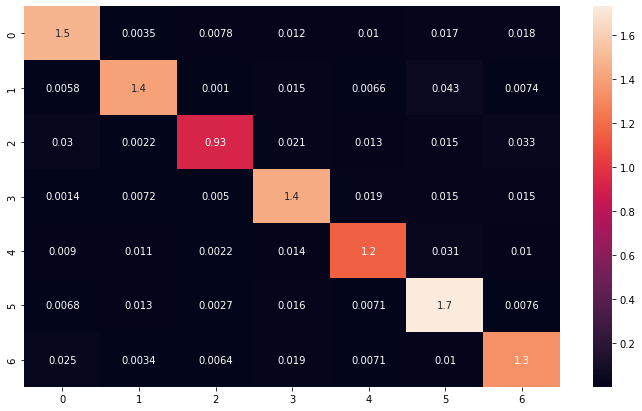

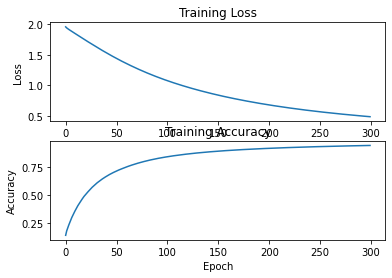

Test Epoch: 0 	Loss: 0.5401	Depression Accuracy: 0.8180


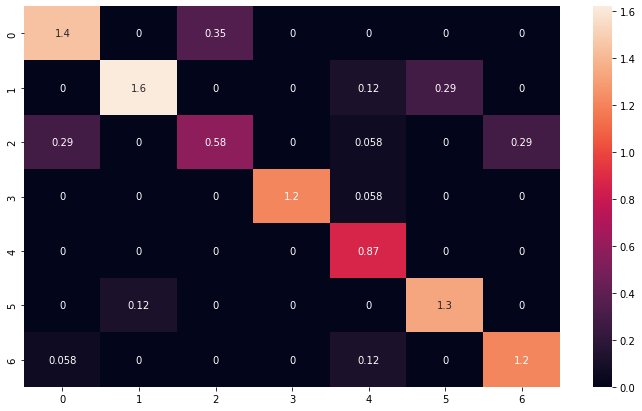

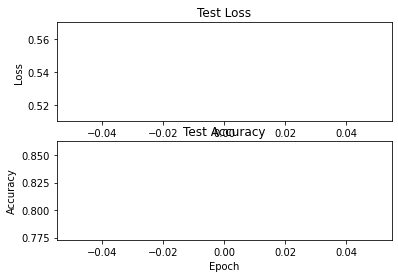

Fold 2
Train Epoch: 299 	Loss: 0.4624	Accuracy: 0.9339


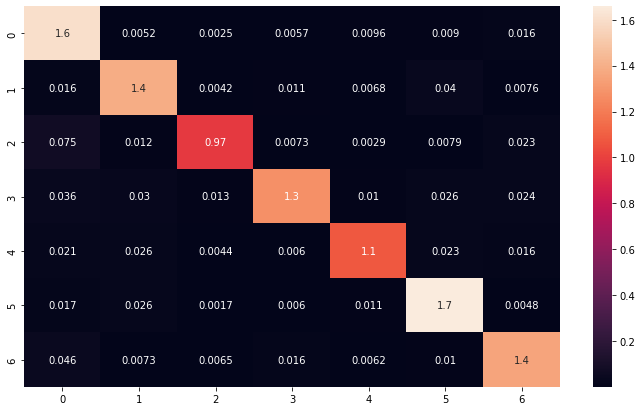

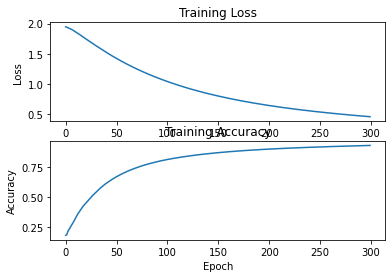

Test Epoch: 0 	Loss: 0.6577	Depression Accuracy: 0.7801


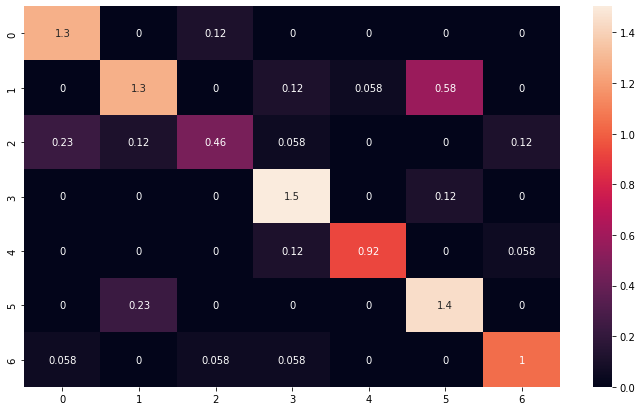

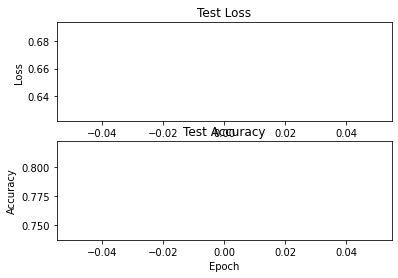

Fold 3
Train Epoch: 299 	Loss: 0.5337	Accuracy: 0.9024


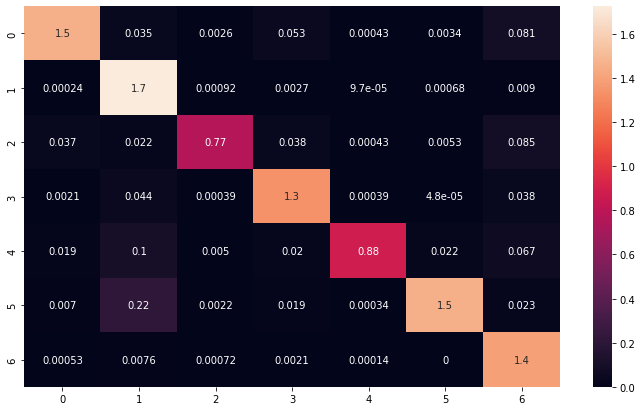

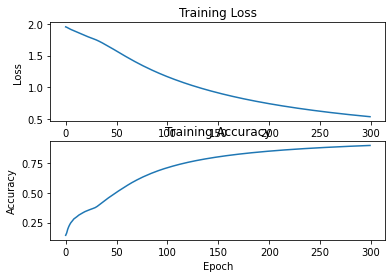

Test Epoch: 0 	Loss: 0.5773	Depression Accuracy: 0.8089


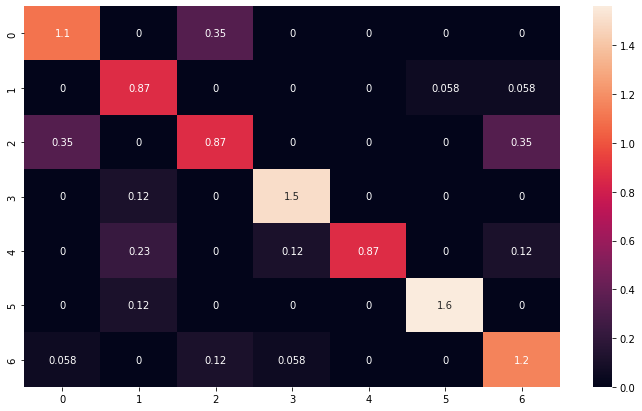

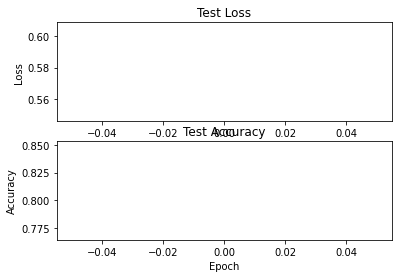

Fold 4
Train Epoch: 299 	Loss: 0.6084	Accuracy: 0.8888


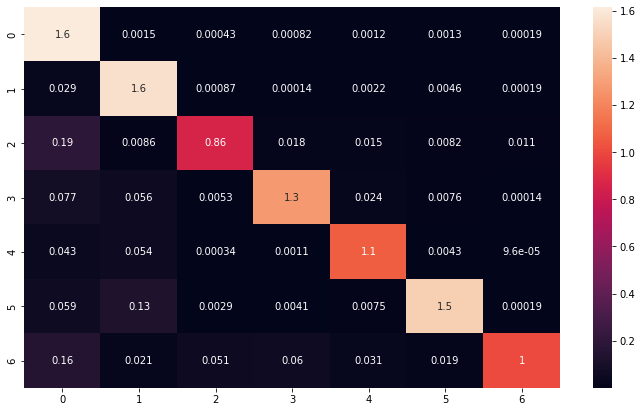

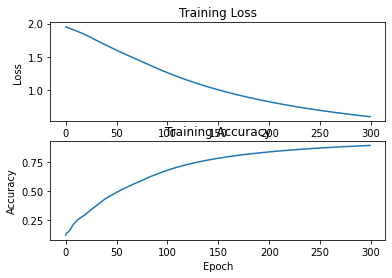

Test Epoch: 0 	Loss: 0.6242	Depression Accuracy: 0.7848


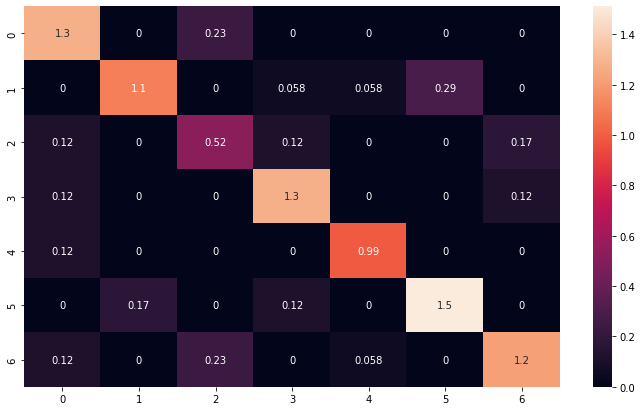

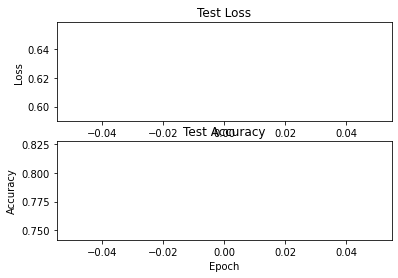

Fold 5
Train Epoch: 299 	Loss: 0.4538	Accuracy: 0.9298


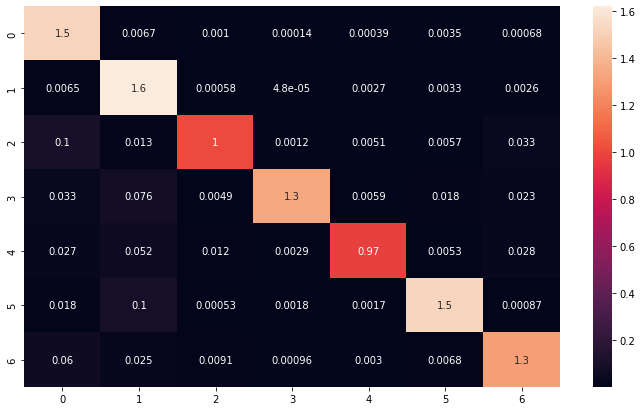

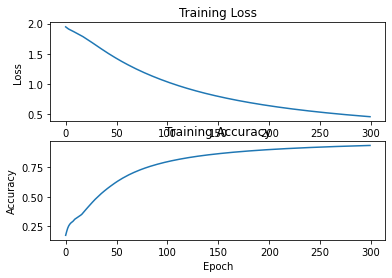

Test Epoch: 0 	Loss: 0.7344	Depression Accuracy: 0.7617


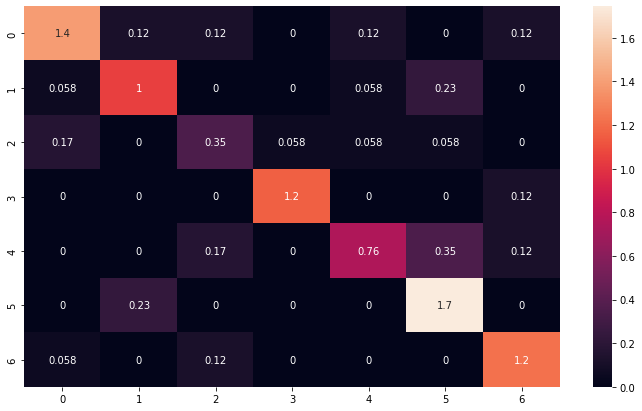

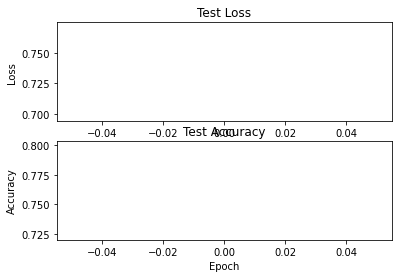

In [ ]:
for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
    print('Fold {}'.format(fold+1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loaderUns = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loaderUns = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

    model = DeepSpeech(
        hparams['n_cnn_layers'],
        hparams['rnn_dim'],
        hparams['h_rnn_layers'],
        hparams['n_rnn_layers'],
        hparams['n_class'],
        hparams['stride'],
        hparams['dropout']
    ).to(device).float()

    optimizer, scheduler = optimizerNet(model, hparams, train_loaderUns)

    trainXD(epochs, model, train_loaderUns, optimizer, criterion_dep, iter_meter)
    testXD(epochs, model, test_loaderUns, optimizer, criterion_anx, iter_meter)

## TORONTO DATA
Same experiment but different dataset.

### DataLoader

Se han truncado las últimas 5000 líneas del flujo de salida.
67
Label: 3	Spectrogram shape: (0, 75, 128)
angry
(73, 128)
73
Label: 3	Spectrogram shape: (0, 75, 128)
angry
(64, 128)
64
Label: 3	Spectrogram shape: (0, 75, 128)
angry
(73, 128)
73
Label: 3	Spectrogram shape: (0, 75, 128)
angry
(66, 128)
66
Label: 3	Spectrogram shape: (0, 75, 128)
angry
(68, 128)
68
Label: 3	Spectrogram shape: (0, 75, 128)
angry
(60, 128)
60
Label: 3	Spectrogram shape: (0, 75, 128)
angry
(64, 128)
64
Label: 3	Spectrogram shape: (0, 75, 128)
angry
(75, 128)
75
Label: 3	Spectrogram shape: (1, 75, 128)
angry
(71, 128)
71
Label: 3	Spectrogram shape: (0, 75, 128)
angry
(74, 128)
74
Label: 3	Spectrogram shape: (0, 75, 128)
angry
(64, 128)
64
Label: 3	Spectrogram shape: (0, 75, 128)
angry
(70, 128)
70
Label: 3	Spectrogram shape: (0, 75, 128)
angry
(65, 128)
65
Label: 3	Spectrogram shape: (0, 75, 128)
angry
(67, 128)
67
Label: 3	Spectrogram shape: (0, 75, 128)
angry
(61, 128)
61
Label: 3	Spectrogram shape: (0, 75, 

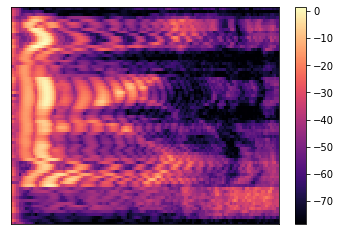

In [ ]:
tpath = "/content/drive/MyDrive/DataSets4Stress/Audio_Emotion/TESS Toronto emotional speech set data"
data = []
audio = []
labels = []
id = []

name = [x[0] for x in os.walk(tpath)]
name.pop(0)
spectrograms = np.zeros((1, 75, 128))

for i,names in enumerate(name):
  print(names)
  file_path = names
  files = os.listdir(file_path)
  
  for j, filename in enumerate(glob.glob(os.path.join(file_path, '*.wav'))):
    x = filename.split("/")
    y = x[7].split("_")
    label = y[1]
    print(str(label))

    sample, sr = librosa.load(filename)
    audio.append(sample)
    duration = len(sample)/sr
    spec = librosa.feature.melspectrogram(
        y= sample,
        sr=sr,
        n_fft= 1024,
        hop_length= 512,
        n_mels= 128,
        fmax= 8000,
        win_length= 400
    )
    spec = librosa.power_to_db(spec).transpose()
    print(spec.shape)
    div = (spec.shape[0] // 75)
    print(spec.shape[0])
    size_new = int(div*75)
    spec = spec[:size_new]
    spec = spec.reshape((div, 75, 128))

    for k in range(div):
      if (label == "Fear") or (label == "fear"):
        lab = int(6)
      elif (label == "Pleasant") or (label == "pleasant"):
        lab = int(5)
      elif (label == "Sad") or (label == "sad"):
        lab = int(4)
      elif label == "angry":
        lab = int(3)
      elif label == "disgust":
        lab = int(2)
      elif label == "happy":
        lab = int(1)
      else:
        lab = int(0)
      
      labels.append(lab)

    spectrograms = np.concatenate((spectrograms, spec))
    print("Label: "+str(lab)+"\tSpectrogram shape: "+str(spec.shape) )
    '''
    if (lab == 5) or (lab == 4) or (lab == 3) or (lab == 0):
      y_noise = sample
      rms = math.sqrt(np.mean(y_noise**2))
      noise = np.random.normal(0, rms, y_noise.shape[0])
      y_noise = y_noise + noise
      spec_t = librosa.feature.melspectrogram(
        y= sample,
        sr=sr,
        n_fft= 1024,
        hop_length= 512,
        n_mels= 128,
        fmax= 8000,
        win_length= 400
      )
      spec_t = librosa.power_to_db(spec_t).transpose()
      div = (spec_t.shape[0] // 75)
      size_new = int(div*75)
      spec_t = spec_t[:size_new]
      spec_t = spec_t.reshape((div, 75, 128))
      for k in range(div):
        labels.append(lab)
      spectrograms = np.concatenate((spectrograms, spec_t))
      print("Data augmented!")'''

plt.figure()
spec = spec.reshape((75,128))
librosa.display.specshow(spec)
plt.colorbar()

In [ ]:
spectrograms = spectrograms[1:,:,:]
print(spectrograms.shape, "Spectrograms array")
print(len(labels))

labels = np.asarray(labels, dtype=int)
dataset = TensorDataset(
    torch.from_numpy(spectrograms),
    torch.from_numpy(labels)
)

(2322, 75, 128) Spectrograms array
2322


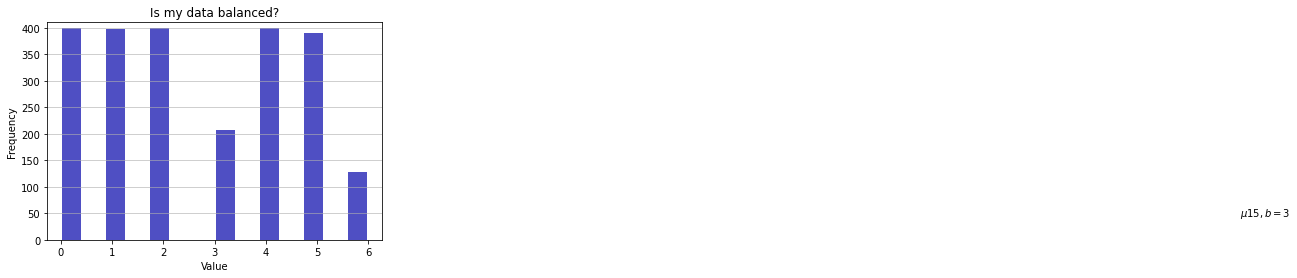

In [ ]:
n, bins, patches = plt.hist(x=labels, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Is my data balanced?')
plt.text(23,45,r'$\mu15, b=3$')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq/10)*10 if maxfreq % 10 else maxfreq + 10)
plt.show()

Fold 1
Train Epoch: 299 	Loss: 0.4410	Accuracy: 0.9476


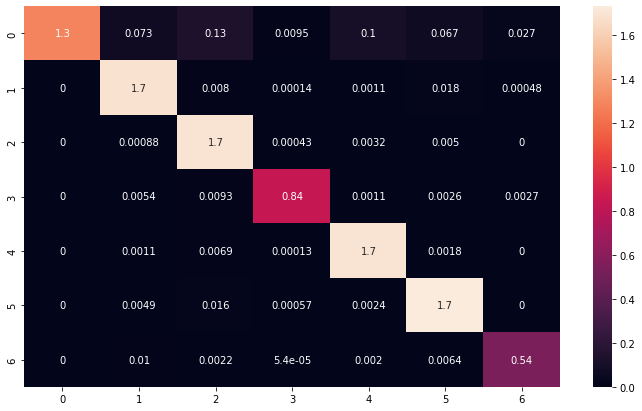

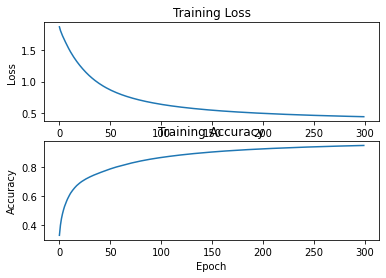

Test Epoch: 0 	Loss: 0.3878	Depression Accuracy: 0.9470


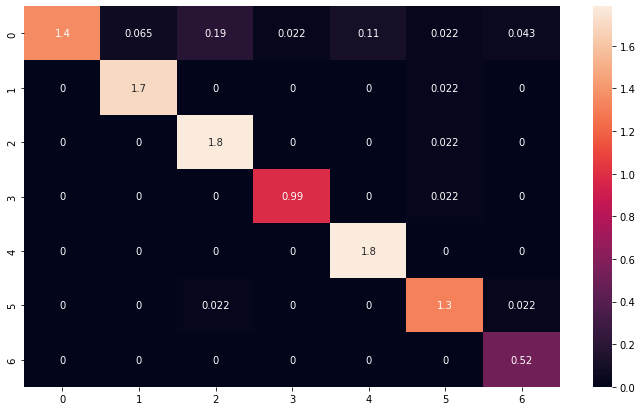

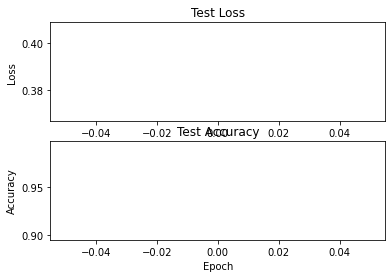

Fold 2
Train Epoch: 299 	Loss: 0.1343	Accuracy: 0.9832


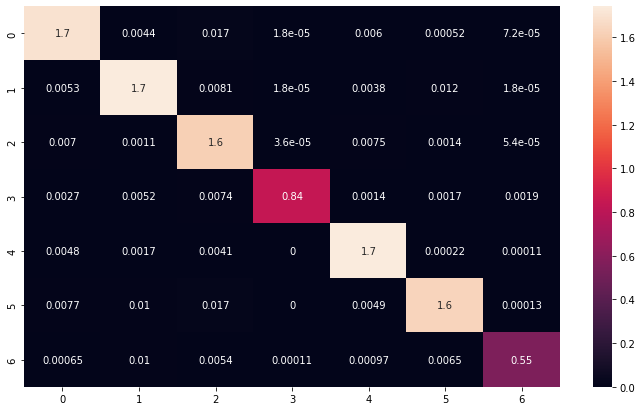

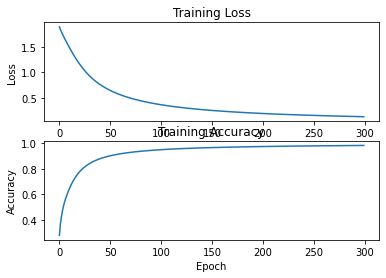

Test Epoch: 0 	Loss: 0.0131	Depression Accuracy: 0.9980


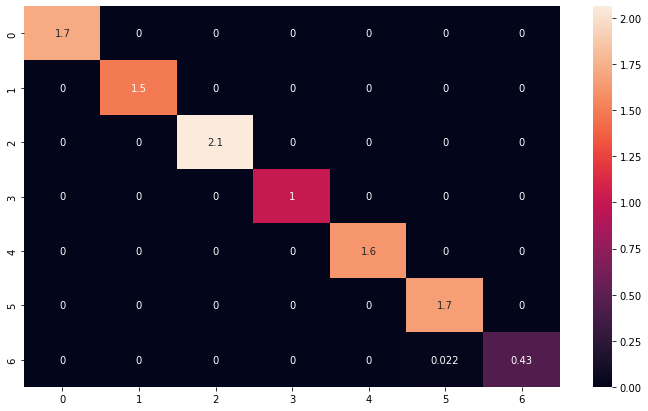

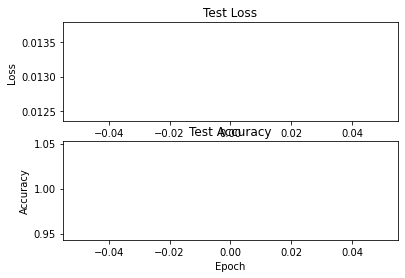

Fold 3
Train Epoch: 299 	Loss: 0.1895	Accuracy: 0.9771


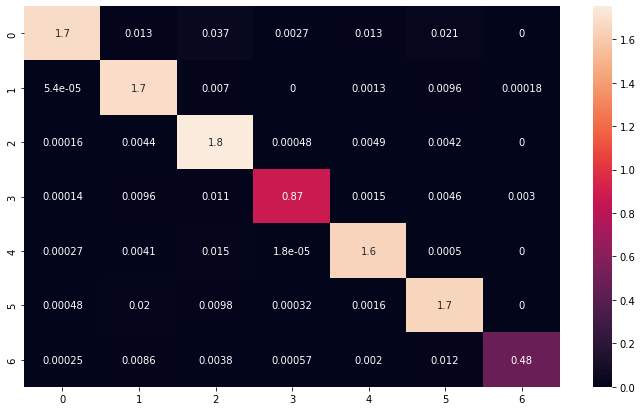

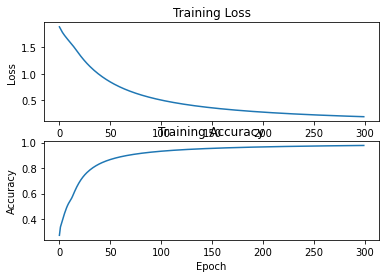

Test Epoch: 0 	Loss: 0.0268	Depression Accuracy: 0.9930


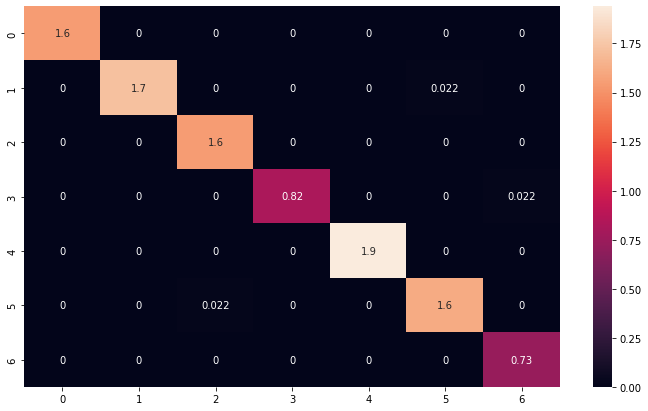

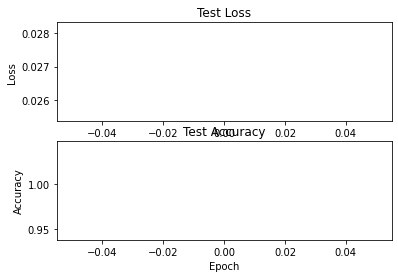

Fold 4
Train Epoch: 299 	Loss: 0.1591	Accuracy: 0.9811


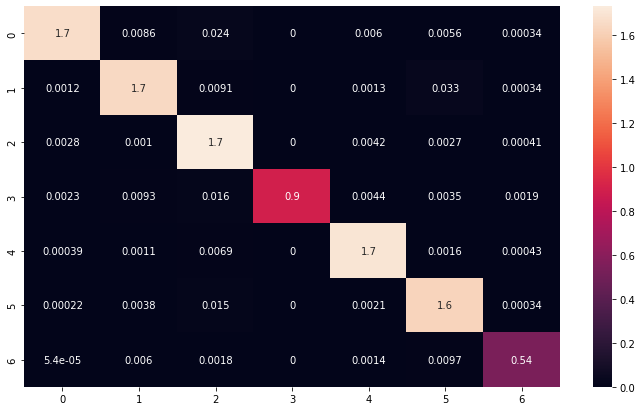

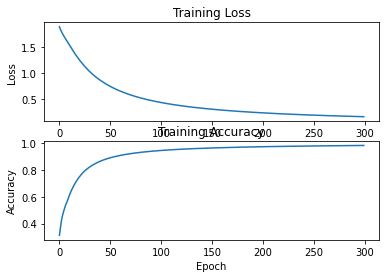

Test Epoch: 0 	Loss: 0.0303	Depression Accuracy: 0.9910


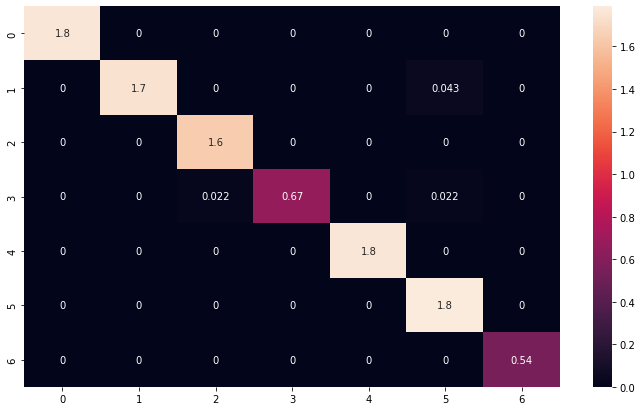

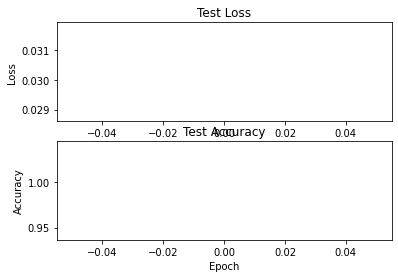

Fold 5
Train Epoch: 299 	Loss: 0.4298	Accuracy: 0.8285


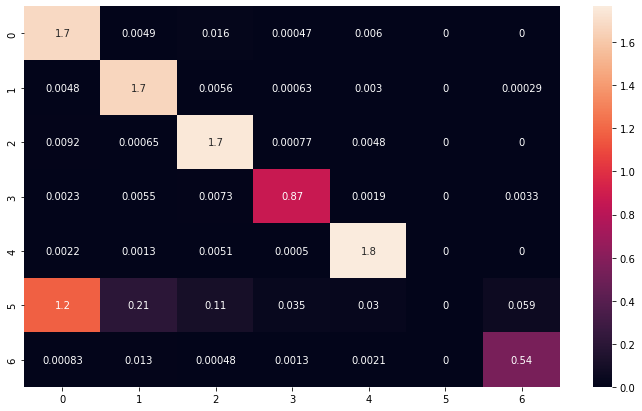

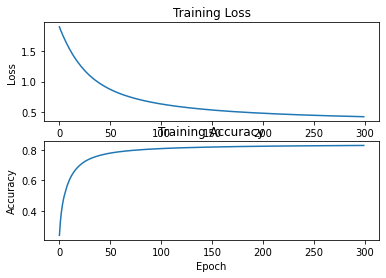

Test Epoch: 0 	Loss: 0.3825	Depression Accuracy: 0.8059


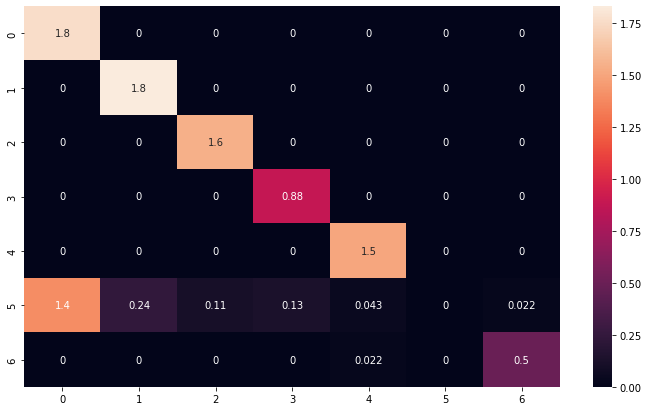

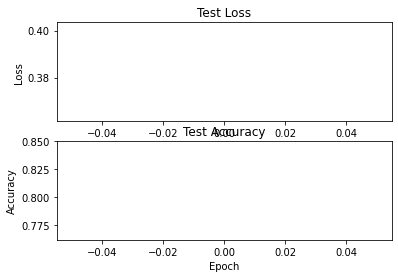

In [ ]:
for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
    print('Fold {}'.format(fold+1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loaderUns = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loaderUns = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

    model = DeepSpeech(
        hparams['n_cnn_layers'],
        hparams['rnn_dim'],
        hparams['h_rnn_layers'],
        hparams['n_rnn_layers'],
        hparams['n_class'],
        hparams['stride'],
        hparams['dropout']
    ).to(device).float()

    optimizer, scheduler = optimizerNet(model, hparams, train_loaderUns)

    trainXD(epochs, model, train_loaderUns, optimizer, criterion_dep, iter_meter)
    testXD(epochs, model, test_loaderUns, optimizer, criterion_anx, iter_meter)

## Using SincNet instead of Mel-Spectrograms

### Custom classes for SincNet Layers.

In [ ]:
import sys
from torch.autograd import Variable

def flip(x,dim):
  xsize = x.size()
  dim = x.dim() + dim if dim < 0 else dim 
  x = x.contiguous()
  x = x.view(-1, *xsize[dim:])
  x = x.view(x.size(0), x.size(1), -1)[:, getattr(torch.arange(x.size(1)-1,-1, -1), ('cpu','cuda')[x.is_cuda])().long(), :]
  return x.view(xsize)

def sinc(band, t_right):
  y_right = torch.sin(2*math.pi*band*t_right)/(2*math.pi*band*t_right)
  y_left = flip(y_right,0)

  y = torch.cat([y_left, Variable(torch.ones(1)),y_right])

  return y

class SincConv(nn.Module):
  def __init__(self, N_filt, Filt_dim, fs):
    super(SincConv,self).__init__()

    #Mel initializing the filterbanks
    low_freq_mel = 80
    high_freq_mel = (2595*np.log10(1+(fs/2)/700))
    mel_points = np.linspace(low_freq_mel, high_freq_mel, N_filt)
    f_cos = (700*(10**(mel_points/2595)-1))
    b1 = np.roll(f_cos,1)
    b2 = np.roll(f_cos,-1)
    b1[0] = 30
    b2[-1] = (fs/2)-100

    self.freq_scale = fs*1.0
    self.filt_b1 = nn.Parameter(torch.from_numpy(b1/self.freq_scale))
    self.filt_band = nn.Parameter(torch.from_numpy((b2-b1)/self.freq_scale))

    self.N_filt = N_filt
    self.Filt_dim = Filt_dim
    self.fs = fs 

  def forward(self,x):

    filters = Variable(torch.zeros(self.N_filt, self.Filt_dim))
    N = self.Filt_dim
    t_right = Variable(torch.linspace(1, (N-1)/2, steps=int((N-1)/2))/self.fs)

    min_freq=50.0;
    min_band=50.0;

    filt_beg_freq = torch.abs(self.filt_b1)+min_freq/self.freq_scale
    filt_end_freq = filt_beg_freq+(torch.abs(self.filt_band)+min_band/self.freq_scale)

    n = torch.linspace(0, N, steps=N)

    #Hamming Window
    window = 0.54-0.46*torch.cos(2*math.pi*n/N);
    window=Variable(window.float())

    for i in range(self.N_filt):
      low_pass1 = 2*filt_beg_freq[i].float()*sinc(filt_beg_freq[i].float()*self.freq_scale,t_right)
      low_pass2 = 2*filt_end_freq[i].float()*sinc(filt_end_freq[i].float()*self.freq_scale,t_right)
      band_pass = (low_pass2-low_pass1)

      band_pass = band_pass/torch.max(band_pass)

      filters[i,:] = band_pass*window

    fil = filters.view(self.N_filt,1,self.Filt_dim)
    print("It's not the conv: ",fil)
    out = F.conv1d(x, fil)
    print("I'm out")
    return out 

In [ ]:
class DeepSpeechSincNet(nn.Module):
    def __init__(self, n_cnn_layers, n_rnn_dim, h_rnn_layer, n_rnn_layers, n_classes,N_filt, Filt_dim, fs, stride=2, dropout=0.1):
        super(DeepSpeechSincNet, self).__init__()
        self.sincnet = SincConv(
            N_filt = N_filt, 
            Filt_dim= Filt_dim, 
            fs=fs
        )

        self.dense = nn.Conv1d(75, 32, 1)
        self.cnn = nn.Sequential(*[
            ResCNN(
                32,
                32
            ) for i in range(n_cnn_layers)
        ])
        self.dense2 = nn.Linear(
            32*128,
            n_rnn_dim
        )
        self.lstm = nn.LSTM(
            input_size= n_rnn_dim,
            hidden_size= h_rnn_layer,
            num_layers= n_rnn_layers,
            batch_first=True,
            bidirectional=True
        )
        self.fc = FullyConnected(
            in_channels= n_rnn_dim,
            out_channels= n_classes
        )

    def forward(self, x):
        batch,freq,width = x.shape
        x = self.sincnet(x)
        print("SincNet shape: ",x.shape)
        x = self.dense(x)
        x = self.cnn(x)
        x = x.view(x.size(0),x.size(1)*x.size(2))
        #x = x.transpose(0,1)
        x = self.dense2(x)
        #x = x.transpose(0,1)
        x,_ = self.lstm(x)
        #x = self.atten(x)
        x = x.transpose(0,1)
        #x = x[:,-1]
        x = x.transpose(0,1)
        x = self.fc(x)
        return x

### Dataset for SincNet (no spectrogram)

In [ ]:
import torchaudio as taudio

tpath = "/content/drive/MyDrive/DataSets4Stress/Audio_Emotion/TESS Toronto emotional speech set data"
data = []
audio = []
labels = []
id = []

name = [x[0] for x in os.walk(tpath)]
name.pop(0)

for i,names in enumerate(name):
  print(names)
  file_path = names
  files = os.listdir(file_path)
  
  for j, filename in enumerate(glob.glob(os.path.join(file_path, '*.wav'))):
    x = filename.split("/")
    y = x[7].split("_")
    label = y[1]
    print(str(label))

    sample, sr = taudio.load(filename, normalize=True)
    audio += [sample]
    #audio.append(sample)
    duration = len(sample)/sr

    if (label == "Fear") or (label == "fear"):
      lab = int(6)
    elif (label == "Pleasant") or (label == "pleasant"):
      lab = int(5)
    elif (label == "Sad") or (label == "sad"):
      lab = int(4)
    elif label == "angry":
      lab = int(3)
    elif label == "disgust":
      lab = int(2)
    elif label == "happy":
      lab = int(1)
    else:
      lab = int(0)
      
    labels.append(lab)
    
    print("Label: "+str(lab)+"\tSample shape: "+str(sample.shape) )

Se han truncado las últimas 5000 líneas del flujo de salida.
disgust
Label: 2	Sample shape: torch.Size([1, 55076])
disgust
Label: 2	Sample shape: torch.Size([1, 56556])
disgust
Label: 2	Sample shape: torch.Size([1, 61153])
disgust
Label: 2	Sample shape: torch.Size([1, 52278])
disgust
Label: 2	Sample shape: torch.Size([1, 53655])
disgust
Label: 2	Sample shape: torch.Size([1, 58314])
disgust
Label: 2	Sample shape: torch.Size([1, 60919])
disgust
Label: 2	Sample shape: torch.Size([1, 56961])
disgust
Label: 2	Sample shape: torch.Size([1, 58243])
disgust
Label: 2	Sample shape: torch.Size([1, 55473])
disgust
Label: 2	Sample shape: torch.Size([1, 56898])
disgust
Label: 2	Sample shape: torch.Size([1, 53998])
disgust
Label: 2	Sample shape: torch.Size([1, 60853])
disgust
Label: 2	Sample shape: torch.Size([1, 61502])
disgust
Label: 2	Sample shape: torch.Size([1, 57918])
disgust
Label: 2	Sample shape: torch.Size([1, 57309])
disgust
Label: 2	Sample shape: torch.Size([1, 55587])
disgust
Label: 2	Samp

In [ ]:
def pad_Audio(batch):
  #Make all tensors in a batch the same length
  batch = [item.t() for item in batch]
  batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
  return batch.permute(0,2,1)

In [ ]:
import torchaudio
def pad_Audio2(batch):
  reshaped = []
  max_samples = batch[0].size(1)
  for x in batch: 
    if x.size(1) > max_samples:
      max_samples = x.size(1)

  for x in batch:
    batches = torchaudio.transforms.PadTrim(max_samples)(x)
    reshaped.append(batches)

  return reshaped

In [1]:
import torch

def make_same_shape(audio_list):
    max_length = max([a.shape[1] for a in audio_list])
    for i, audio in enumerate(audio_list):
        if audio.shape[1] < max_length:
            padding = torch.zeros(audio.shape[0], max_length - audio.shape[1])
            audio_list[i] = torch.cat((audio, padding), dim=1)
        else:
            audio_list[i] = audio[:, :max_length]
    return audio_list

In [ ]:
output = pad_Audio(audio)
print("Labels jeje: ",len(labels))
print("Batched sequence: ",output.shape)
print(output)

Labels jeje:  2810
Batched sequence:  torch.Size([2810, 1, 145172])
tensor([[[ 0.0000e+00, -9.1553e-05, -1.2207e-04,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00, -6.1035e-05, -9.1553e-05,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00, -1.2207e-04, -6.1035e-05,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        ...,

        [[ 0.0000e+00, -6.1035e-05, -9.1553e-05,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00, -9.1553e-05, -1.2207e-04,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00, -6.1035e-05, -1.5259e-04,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]]])


In [ ]:
labels = np.asarray(labels, dtype=int)
#audio = np.asarray(output, dtype=int)
#audio = torch.stack(output)
dataset = TensorDataset(
    output,
    torch.from_numpy(labels)
)

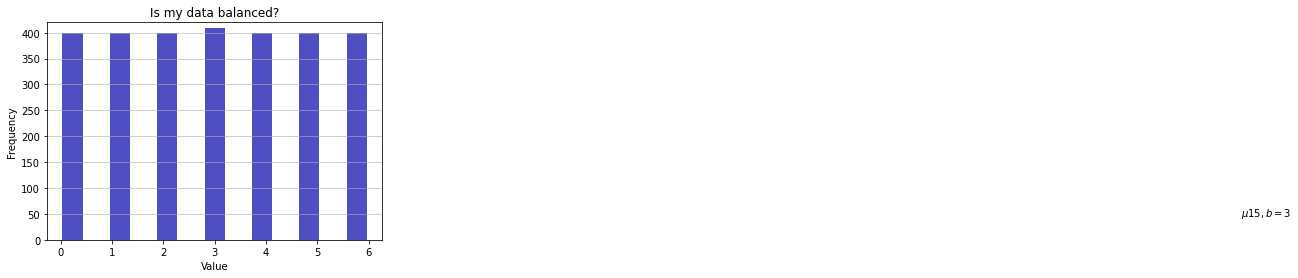

In [ ]:
n, bins, patches = plt.hist(x=labels, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Is my data balanced?')
plt.text(23,45,r'$\mu15, b=3$')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq/10)*10 if maxfreq % 10 else maxfreq + 10)
plt.show()

In [ ]:
#Constants
learning_Rate = 0.0005
batch_size = 128
epochs = 300
k=5
splits=KFold(n_splits=k,shuffle=True,random_state=42)
foldperf={}

hparams = {
    "n_cnn_layers": 6,
    "n_rnn_layers": 1,
    "rnn_dim": 256,
    "h_rnn_layers": 128,
    "n_class": 7,
    "n_feats": 64,
    "N_filt": 128, 
    "Filt_dim": 1023, 
    "fs": sr,
    "stride": 2,
    "dropout": 0.3,
    "learning_rate": learning_Rate,
    "batch_size": batch_size,
    "epochs": epochs
}

use_cuda = torch.cuda.is_available()
torch.manual_seed(7)
device = torch.device("cuda" if use_cuda else "cpu")

k=5
splits=KFold(n_splits=k,shuffle=True,random_state=42)
foldperf={}

#Optimizing Model
weights = [0.9,0.9,0.9,1.0,0.9,0.9,1.0]
class_weights = torch.FloatTensor(weights)
criterion_dep = nn.CrossEntropyLoss(weight=class_weights).to(device)
criterion_anx = nn.CrossEntropyLoss().to(device)
iter_meter = IterMeter()

In [ ]:
for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
    print('Fold {}'.format(fold+1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loaderUns = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loaderUns = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

    model = DeepSpeechSincNet(
        hparams['n_cnn_layers'],
        hparams['rnn_dim'],
        hparams['h_rnn_layers'],
        hparams['n_rnn_layers'],
        hparams['n_class'],
        hparams['N_filt'],
        hparams['Filt_dim'],
        hparams['fs']
    ).to(device).float()

    optimizer, scheduler = optimizerNet(model, hparams, train_loaderUns)

    trainXD(epochs, model, train_loaderUns, optimizer, criterion_dep, iter_meter)
    testXD(epochs, model, test_loaderUns, optimizer, criterion_anx, iter_meter)

Fold 1
It's not the conv:  tensor([[[ 0.0050,  0.0052,  0.0054,  ...,  0.0054,  0.0052,  0.0050]],

        [[-0.0096, -0.0098, -0.0099,  ..., -0.0099, -0.0098, -0.0096]],

        [[ 0.0062,  0.0061,  0.0059,  ...,  0.0059,  0.0061,  0.0062]],

        ...,

        [[-0.0006,  0.0009, -0.0011,  ..., -0.0011,  0.0009, -0.0006]],

        [[ 0.0004, -0.0005,  0.0005,  ...,  0.0005, -0.0005,  0.0004]],

        [[ 0.0010, -0.0012,  0.0013,  ...,  0.0013, -0.0012,  0.0010]]],
       grad_fn=<ViewBackward0>)
